In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':15})
import pandas as pd
from sklearn.mixture import GaussianMixture as GM
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from joblib import Parallel, delayed
import scipy as sp
from scipy.spatial.distance import jensenshannon as jsd
import itertools

In [2]:
reduced_metnames = [['Propionate'            ],
    # ['A2BRatio'              ],
    ['Glucose'               ],
    ['NEFA'                  ],
    ['Lactosegkg'            ],
    ['RumenpH'               ],
    ['Starch1'               ],
    ['Valerate'              ],
    ['Lactose'               ],
    ['TotalVFA'              ],
    ['archaea_count_mean'    ],
    ['EnergycorrectedmilkECM'],
    ['Creatinine'            ],
    ['FCM'                   ],
    ['NRC_DMI'               ],
    ['Fat'                   ],
    ['Milk'                  ],
    ['Protein'               ],
    ['DM2'                   ],
    ['Urea'                  ],
    ['Daysinmilk'            ],
    ['gkgECM'                ],
    ['Isobutyrate'           ],
    ['Ammonia'               ],
    ['ECMDMI'                ],
    ['FCEfcm'                ],
    ['Acetate'               ],
    ['FCEecm'                ],
    ['BHB'                   ],
    ['FCEsolids'             ],
    ['Cholesterol'           ],
    ['Butyrate'              ],
    # ['RFINRC'                ],
    ['protozoa_count_mean'   ],
    ['Liveweightkg'          ],
    # ['Haptoglobulin'         ],
    ['Albumin'               ],
    ['Proteingkg'            ],
    ['gkgDMI'                ],
    ['bacteria_count_mean'   ],
    ['gd'                    ],
    ['OM1'                   ],
    ['Fatgkg'                ],
    ['CP1'                   ],
    ['Isovalerate'           ],
    ['NDF1'                  ]]

In [79]:
tax = pd.read_csv('data_files/taxonomy.csv')

(17364, 8)

In [3]:
metadata = np.array(pd.read_csv('data_files/metadata_cow_1.csv', index_col=0))
cow_data = np.array(pd.read_csv('data_files/data_COWS.csv', index_col=0))
metnames = np.array(pd.read_csv('data_files/metnames.csv', index_col=0)).reshape(-1)
metnames = np.array([elem.replace("'", "").strip("[]") for elem in metnames])

# Train phenotype obj to get z, theta and C
z = np.array(pd.read_csv('fig_3_files/combined_latents.csv', index_col=0))
theta = np.array(pd.read_csv('fig_3_files/theta.csv', index_col=0))
C = np.array(pd.read_csv('fig_3_files/metadata_theta.csv', index_col=0))[:, np.isin(metnames, reduced_metnames)]

metadata = metadata[:, np.isin(metnames, reduced_metnames)]
metadata_means = np.mean(metadata, axis=0)
metadata_stds = np.std(metadata, axis=0)
metadata = (metadata - metadata_means[np.newaxis, :])/metadata_stds[np.newaxis, :]
metnames = metnames[np.isin(metnames, reduced_metnames)]

In [4]:
reconstructed_data = np.exp(np.matmul(-z, theta))
reconstructed_data /= np.sum(reconstructed_data, axis=1)[:, np.newaxis]
reconstructed_metadata = np.matmul(z, C)

# Fit mixture gaussian on latent space

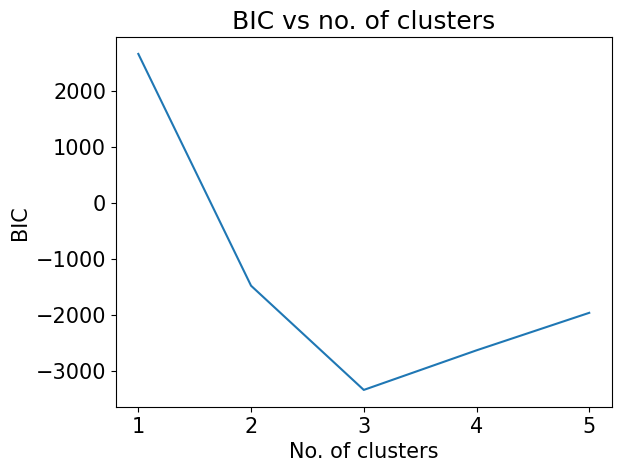

In [6]:
bic_list = []
for i in range(1, 6):
    best_score = -np.inf
    best_model = None
    for _ in range(100):
        gm = GM(n_components=i).fit(z)
        current_score = gm.score(z)
        if current_score > best_score:
            best_score = current_score
            best_model = gm
    bic_list.append(best_model.bic(z))

plt.plot(np.arange(1,6), bic_list)
plt.xticks(np.arange(1,6))
plt.title('BIC vs no. of clusters')
plt.xlabel('No. of clusters')
plt.ylabel('BIC')
plt.show()

In [7]:
best_score = -np.inf
best_model = None
for _ in range(100):
    gmm = GM(n_components=3).fit(z)
    current_score = gmm.score(z)
    if current_score > best_score:
        best_score = current_score
        best_model = gmm

# Generate biased synthetic data

In [8]:
def process_sample(gm, C, id1, id2, nK, gamm, nIter):
    ZO = gm.sample()[0]  # Sample from the Gaussian mixture model
    sample_met = np.matmul(ZO.reshape(-1), C)*metadata_stds + metadata_means

    while np.any(sample_met < 0):
        ZO = gm.sample()[0]  # Sample from the Gaussian mixture model
        sample_met = np.matmul(ZO.reshape(-1), C)*metadata_stds + metadata_means

    ZN = ZO.copy()
    eO = np.inf

    for iter in range(1, nIter + 1):
        ZN = ZO + 0.01 * np.random.randn(1, nK) * (np.random.rand(1, nK) > 0.5)
        M = np.dot(ZN, C).reshape(-1)
        m1 = M[id1]
        m2 = M[id2]
        eN = (-gm.score_samples(ZN) + gamm * (m1 - 3)**2 + gamm * (m2 - 3)**2)[0] #Hard coded biases need adjustment depending on need

        energy_diff = (eN - eO)
        if np.exp(-energy_diff) > np.random.rand():
            eO = eN
            ZO = ZN.copy()

    M = np.dot(ZO, C).reshape(-1)
    return (M[id1], M[id2]), ZO.flatten()

def generate_synthetic_data(gm, C, id1, id2, nK, gamm=2, nIter=25000, nSamples=500, n_jobs=-1):
    '''
    
    '''
    results = Parallel(n_jobs=n_jobs)(delayed(process_sample)(gm, C, id1, id2, nK, gamm, nIter) for _ in range(nSamples))
    
    gx = np.zeros((nSamples, 2))
    Zx = []

    for ct, (result_gx, result_Zx) in enumerate(results):
        gx[ct, :] = result_gx
        Zx.append(result_Zx)

    Zx = np.array(Zx)
    return gx, Zx

Get indices of phenotypes of interest

In [7]:
id1 = np.where(metnames == 'Starch1')[0][0]
id2 = np.where(metnames == 'RumenpH')[0][0]
id3 = np.where(metnames == 'Propionate')[0][0]

In [52]:
gx, Zx = generate_synthetic_data(best_model, C, id1, id2, z.shape[1], gamm=2, nIter=25000, nSamples=500) #Biased high starch and ph
gx1, Zx1 = generate_synthetic_data(best_model, C, id1, id2, z.shape[1], gamm=0, nIter=25000, nSamples=500)
gx3, Zx3 = generate_synthetic_data(best_model, C, id2, id3, z.shape[1], gamm=2, nIter=25000, nSamples=500) #Biased high ph and propionate
gx2, Zx2 = generate_synthetic_data(best_model, C, id2, id3, z.shape[1], gamm=0, nIter=25000, nSamples=500)

In [67]:
gz_dict = [{'gx': gx.tolist(), 'Zx': Zx.tolist()}, {'gx': gx1.tolist(), 'Zx': Zx1.tolist()}, {'gx': gx2.tolist(), 'Zx': Zx2.tolist()}, {'gx': gx3.tolist(), 'Zx': Zx3.tolist()}]

Saving and loading data

In [68]:
import json
# Write JSON string to a file
with open('fig_5_files/gz_dict.json', 'w') as json_file:
    json.dump(gz_dict, json_file, indent=4)

In [4]:
import json
with open('fig_5_files/gz_dict.json', 'r') as json_file:
    gz_dict = json.load(json_file)

In [5]:
gx, Zx = np.array(gz_dict[0]['gx']), np.array(gz_dict[0]['Zx']) # High stach and pH
gx1, Zx1 = np.array(gz_dict[1]['gx']), np.array(gz_dict[1]['Zx'])
gx2, Zx2 = np.array(gz_dict[2]['gx']), np.array(gz_dict[2]['Zx']) # High pH and propionate
gx3, Zx3 = np.array(gz_dict[3]['gx']), np.array(gz_dict[3]['Zx'])

In [8]:
gx_scaled = np.multiply(gx, metadata_stds[[id1, id2]]) + metadata_means[[id1, id2]]
gx1_scaled = np.multiply(gx1, metadata_stds[[id1, id2]]) + metadata_means[[id1, id2]]
gx2_scaled = gx2*metadata_stds[[id2, id3]] + metadata_means[[id2, id3]]
gx3_scaled = gx3*metadata_stds[[id2, id3]] + metadata_means[[id2, id3]]

In [29]:
def plot_contour(data, levels=[0.05, 0.1, 0.15, 0.2], color='black', bandwidth=0.5):
    # Calculate mean and std for standardization
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data_z = (data - mean[np.newaxis, :]) / std[np.newaxis, :]

    # Extract x and y
    x = data[:, 0]
    y = data[:, 1]

    # Standardized x and y
    x_z = data_z[:, 0]
    y_z = data_z[:, 1]

    # Fit KDE on standardized data
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(data_z)

    # Create grid for standardized data
    x_grid = np.linspace(min(x_z), max(x_z), 100)
    y_grid = np.linspace(min(y_z), max(y_z), 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    Z = np.exp(kde.score_samples(xy)).reshape(X.shape)

    # Create grid for original data
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = np.linspace(min(y), max(y), 100)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Plot contour
    contour = plt.contour(X, Y, Z, levels=levels, colors=color)
    plt.clabel(contour, inline=True, fontsize=8)

    # Plot original data points for reference
    # plt.scatter(x, y, s=10, color=color, alpha=0.1)
    # plt.title('Contour plot with KDE')
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.show()

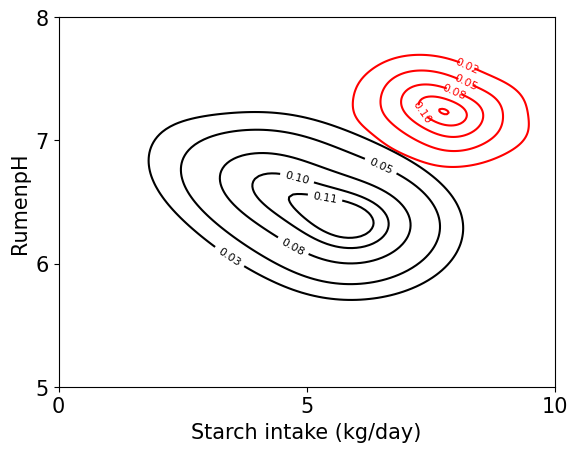

In [70]:
plot_contour(gx_scaled, levels=[0.02, 0.05, 0.08, 0.1, 0.11],color='red', bandwidth=0.6)
plt.ylim([5, 8])
plt.xlim([0, 10])
plot_contour(gx1_scaled, levels=[0.03, 0.05, 0.08, 0.1, 0.11], bandwidth=0.6)
plt.xlabel('Starch intake (kg/day)')
plt.ylabel('RumenpH')
plt.xticks([0, 5, 10])
plt.yticks([5, 6, 7, 8])
plt.savefig('figures/biased_contour.pdf', dpi=300, format='pdf')
plt.show()

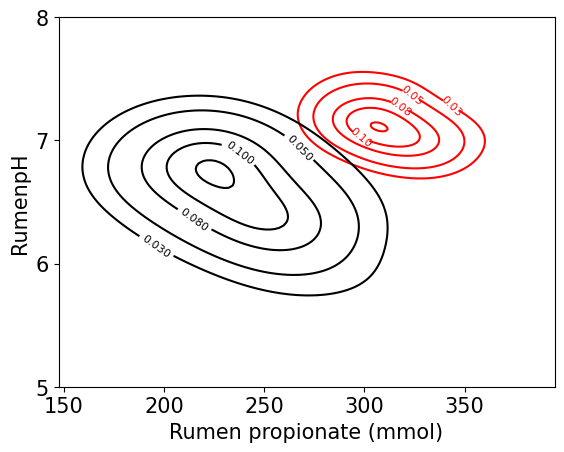

In [74]:
plot_contour(gx3_scaled[:, ::-1], levels=[0.03, 0.05, 0.08, 0.1, 0.12],color='red', bandwidth=0.6)
# plt.ylim([5, 8])
# plt.xlim([0, 10])
plot_contour(gx2_scaled[:, ::-1], levels=[0.03, 0.05, 0.08, 0.1, 0.115], bandwidth=0.6)
plt.xlabel('Rumen propionate (mmol)')
plt.ylabel('RumenpH')
# plt.xticks([0, 5, 10])
plt.yticks([5, 6, 7, 8])
plt.ylim(5, 8)
plt.savefig('figures/biased_contour_2.pdf', dpi=300, format='pdf')
plt.show()

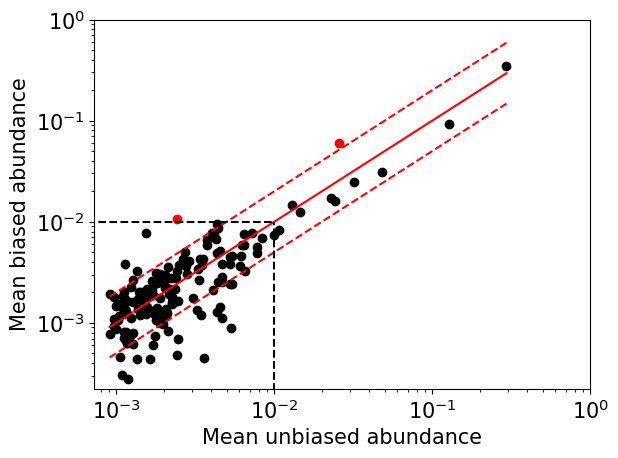

In [9]:
unbiased_data = np.exp(np.matmul(-Zx1, theta))
unbiased_data /= np.sum(unbiased_data, axis=1)[:, np.newaxis]

biased_data = np.exp(np.matmul(-Zx, theta))
biased_data /= np.sum(biased_data, axis=1)[:, np.newaxis]

mean_unbiased = unbiased_data.mean(axis=0)
mean_biased = biased_data.mean(axis=0)

x = np.linspace(mean_unbiased.min(), mean_unbiased.max(), 100)
y1 = 2*x
y2 = x/2

plt.plot(x, x, color='red')
plt.plot(x, y1, '--', color='red')
plt.plot(x, y2, '--', color='red')

x = np.linspace(1e-2, 1e-2, 100)
y = np.linspace(1e-4,1e-2, 100)

plt.plot(x, y, '--', color='black')
plt.plot(y, x, '--', color='black')

unchanged_idx = (mean_biased <= 2*mean_unbiased) & (mean_biased >= mean_unbiased/2) | (mean_biased < 1e-2)
# changed_idx = (mean_biased > 2*mean_unbiased) | (mean_biased < mean_unbiased/2)
# print(unchanged_idx)


plt.scatter(mean_unbiased[unchanged_idx==True], mean_biased[unchanged_idx==True], color='black')
plt.scatter(mean_unbiased[unchanged_idx==False], mean_biased[unchanged_idx==False], color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean unbiased abundance')
plt.ylabel('Mean biased abundance')
plt.xlim([mean_unbiased.min()*0.8, 1])
plt.ylim([mean_biased.min()*0.8, 1])
# plt.savefig('figures/biased_vs_unbiased_mean.pdf', dpi=300, format='pdf')
plt.show()

In [106]:
cow_tax[unchanged_idx==False][:, -3:-1]

array([['Succinivibrionaceae', 'Succinivibrionaceae_UCG-002'],
       ['Succinivibrionaceae', 'Ruminobacter']], dtype=object)

In [109]:
np.where(cow_tax[:, -3] == 'Succinivibrionaceae')[0].shape

(12,)

In [110]:
np.where(cow_tax[:, -2] == 'Ruminobacter')[0].shape

(2,)

In [83]:
survived_indices = np.loadtxt("data_files/cow_survived_indices.csv", delimiter=",").astype(np.int64)
taxonomy = pd.read_csv('data_files/taxonomy.csv')
taxonomy.replace('<undefined>', np.nan, inplace=True)
taxonomy = taxonomy.drop('VarName1', axis=1)
taxonomy = np.array(taxonomy)

In [91]:
cow_tax = np.vstack((taxonomy[survived_indices], [np.nan]*7))
cow_tax[:, 1:-1].shape

(157, 5)

In [95]:
mean_unbiased.shape

(157,)

In [96]:
si_table_4 = {'Taxonomy (Phylum, Class, Order, Family, Genus)': cow_tax[:, 1:-1].tolist(), 'Average abundance in unbiased samples': mean_unbiased, 'Average abundance in biased samples': mean_biased, 'Fold change': mean_biased/mean_unbiased}

df = pd.DataFrame(si_table_4)
df.head()

,"Taxonomy (Phylum, Class, Order, Family, Genus)",Average abundance in unbiased samples,Average abundance in biased samples,Fold change
0,"[Proteobacteria, Gammaproteobacteria, Aeromona...",0.127020,0.092801,0.730597
1,"[Bacteroidota, Bacteroidia, Bacteroidales, Pre...",0.022990,0.017322,0.753463
2,"[Bacteroidota, Bacteroidia, Bacteroidales, Pre...",0.004321,0.004928,1.140528
3,"[Proteobacteria, Gammaproteobacteria, Aeromona...",0.003371,0.004239,1.257303
4,"[Bacteroidota, Bacteroidia, Bacteroidales, Pre...",0.002476,0.000686,0.277174


In [98]:
df.to_csv('data_files/si_table_4.csv', index=False)

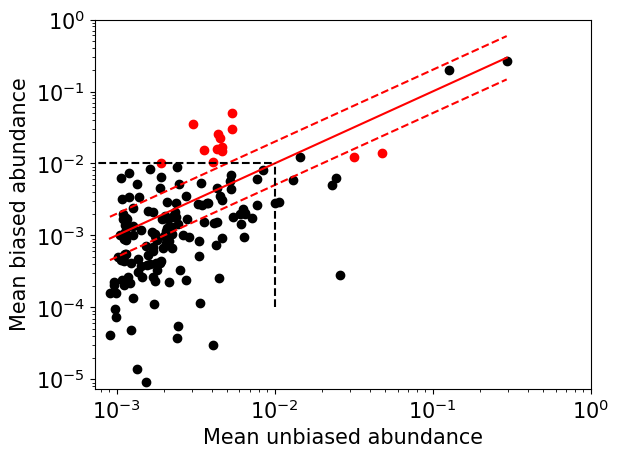

In [59]:
unbiased_data = np.exp(np.matmul(-Zx2, theta))
unbiased_data /= np.sum(unbiased_data, axis=1)[:, np.newaxis]

biased_data = np.exp(np.matmul(-Zx3, theta))
biased_data /= np.sum(biased_data, axis=1)[:, np.newaxis]

mean_unbiased = unbiased_data.mean(axis=0)
mean_biased = biased_data.mean(axis=0)

x = np.linspace(mean_unbiased.min(), mean_unbiased.max(), 100)
y1 = 2*x
y2 = x/2

plt.plot(x, x, color='red')
plt.plot(x, y1, '--', color='red')
plt.plot(x, y2, '--', color='red')

x = np.linspace(1e-2, 1e-2, 100)
y = np.linspace(1e-4,1e-2, 100)

plt.plot(x, y, '--', color='black')
plt.plot(y, x, '--', color='black')

unchanged_idx = (mean_biased <= 2*mean_unbiased) & (mean_biased >= mean_unbiased/2) | (mean_biased < 1e-2)
# changed_idx = (mean_biased > 2*mean_unbiased) | (mean_biased < mean_unbiased/2)
# print(unchanged_idx)


plt.scatter(mean_unbiased[unchanged_idx==True], mean_biased[unchanged_idx==True], color='black')
plt.scatter(mean_unbiased[unchanged_idx==False], mean_biased[unchanged_idx==False], color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean unbiased abundance')
plt.ylabel('Mean biased abundance')
plt.xlim([mean_unbiased.min()*0.8, 1])
plt.ylim([mean_biased.min()*0.8, 1])
plt.savefig('figures/biased_vs_unbiased_mean_2.pdf', dpi=300, format='pdf')
plt.show()

In [60]:
metnames

array(['Daysinmilk', 'Liveweightkg', 'OM1', 'CP1', 'NDF1', 'Starch1',
       'DM2', 'Milk', 'Fat', 'Protein', 'Lactose', 'FCM',
       'EnergycorrectedmilkECM', 'Fatgkg', 'Proteingkg', 'Lactosegkg',
       'ECMDMI', 'NRC_DMI', 'FCEecm', 'FCEfcm', 'FCEsolids', 'RumenpH',
       'TotalVFA', 'Acetate', 'Propionate', 'Butyrate', 'Isobutyrate',
       'Valerate', 'Isovalerate', 'Ammonia', 'gd', 'gkgDMI', 'gkgECM',
       'NEFA', 'BHB', 'Glucose', 'Urea', 'Cholesterol', 'Creatinine',
       'Albumin', 'protozoa_count_mean', 'archaea_count_mean',
       'bacteria_count_mean'], dtype='<U22')

In [61]:
unbiased_meta = np.matmul(Zx2, C)*metadata_stds + metadata_means
biased_meta = np.matmul(Zx3, C)*metadata_stds + metadata_means

metabolites = ['Acetate', 'Propionate', 'Butyrate', 'Isobutyrate', 'Valerate', 'Isovalerate']
biased_levels = biased_meta[:, np.isin(metnames, metabolites)]
unbiased_levels = unbiased_meta[:, np.isin(metnames, metabolites)]

mean_biased_levels = np.mean(biased_levels, axis=0)
mean_unbiased_levels = np.mean(unbiased_levels, axis=0)

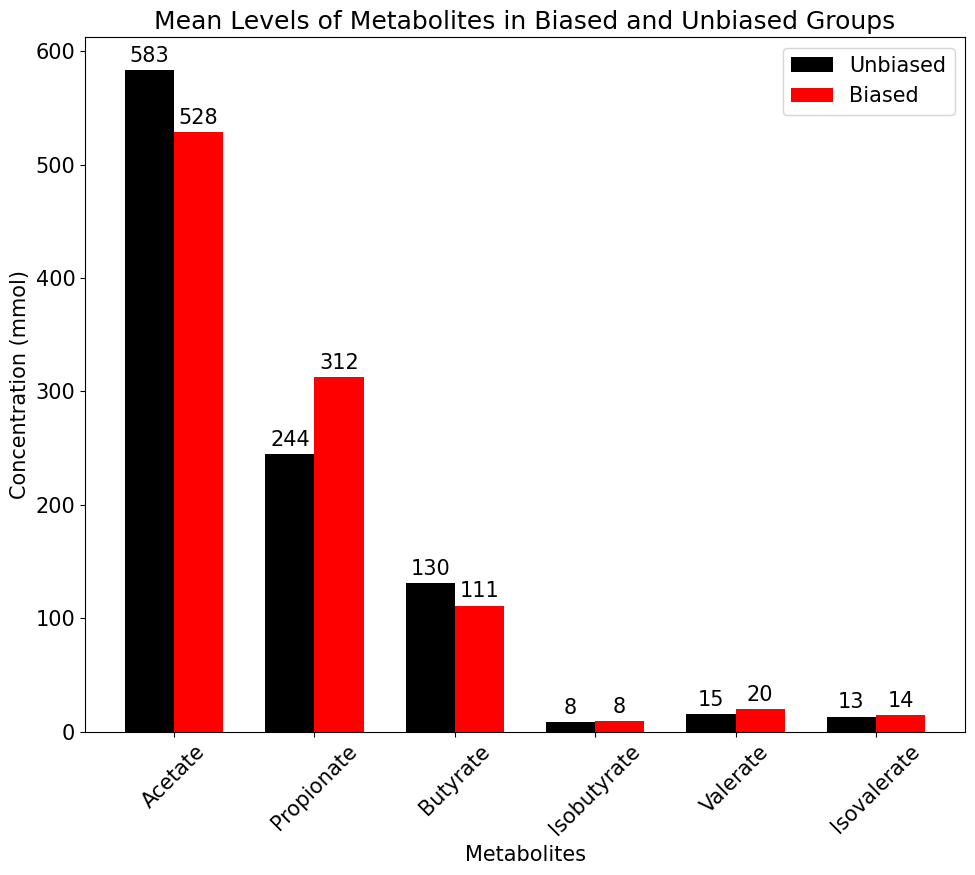

In [62]:
# Creating the bar chart
x = np.arange(len(metabolites))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 9))
bars1 = ax.bar(x - width/2, mean_unbiased_levels, width, label='Unbiased', color='black')
bars2 = ax.bar(x + width/2, mean_biased_levels, width, label='Biased', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metabolites')
ax.set_ylabel('Concentration (mmol)')
ax.set_title('Mean Levels of Metabolites in Biased and Unbiased Groups')
ax.set_xticks(x)
ax.set_xticklabels(metabolites)
ax.set_xticklabels(metabolites, rotation=45)
ax.legend()

# Add the mean value labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

fig.tight_layout()
plt.savefig('figures/fig_4_b.pdf', dpi=300, format='pdf')
plt.show()

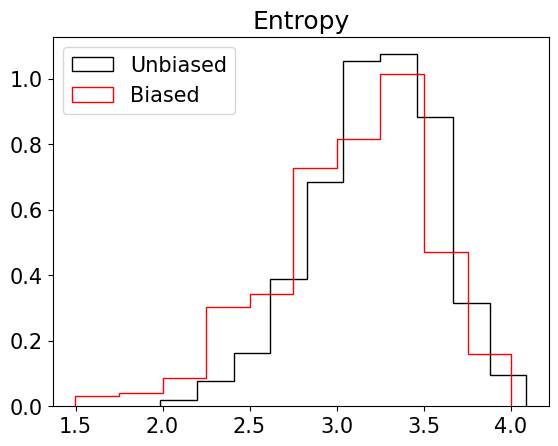

In [10]:
biased_shannon = sp.stats.entropy(biased_data.T)
unbiased_shannon = sp.stats.entropy(unbiased_data.T)

plt.hist(unbiased_shannon, histtype='step', label='Unbiased', color='black', density=True)
plt.hist(biased_shannon, histtype='step', label='Biased', color='red', density=True)
plt.legend()
plt.title('Entropy')
plt.savefig('figures/biased_vs_unbiased_shannon.pdf', format='pdf')
plt.show()

In [12]:
def jsd_matrix(data):
    data_comb = itertools.combinations(data, 2)
    jsd_list = np.array([jsd(comb[0], comb[1]) for comb in data_comb])
    return np.array(jsd_list)

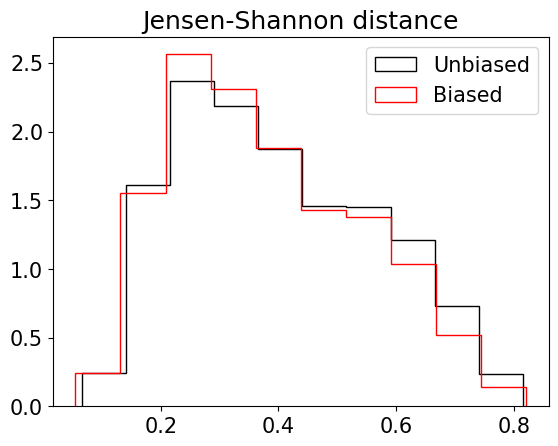

In [13]:
biased_jsd = jsd_matrix(biased_data.T)
unbiased_jsd = jsd_matrix(unbiased_data.T)

plt.hist(unbiased_jsd, histtype='step', color='black', label='Unbiased', density=True)
plt.hist(biased_jsd, histtype='step', color='red', label='Biased', density=True)
plt.legend()
plt.title('Jensen-Shannon distance')
plt.savefig('figures/biased_vs_unbiased_jsd.pdf', format='pdf')
plt.show()

In [24]:
def make_inv_cummulative_abundance_plot(data, label=None):
    x_data = np.sort(data[np.nonzero(data)], axis=None)
    inv_cum = np.cumsum(x_data)
    inv_cum = inv_cum[-1] - inv_cum
    inv_cum = inv_cum / inv_cum[0]
    #print('Sum:', inv_cum[0])
    plt.plot(x_data, inv_cum, label=label)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Inverse cumulative abundance distribution')
    plt.xlim(1e-4,1)
    plt.ylim(1e-3,2)
    # plt.show()

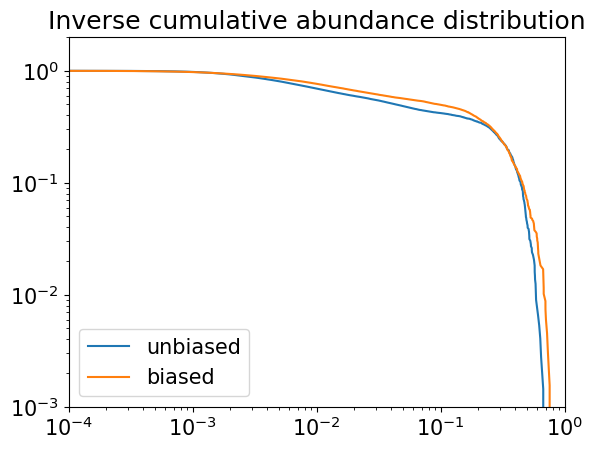

In [25]:
make_inv_cummulative_abundance_plot(unbiased_data, 'unbiased')
make_inv_cummulative_abundance_plot(biased_data, 'biased')
plt.legend()
plt.show()